In [1]:
#!pip install mkl-service
#!pip install pymc3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 852.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats
from patsy import bs, dmatrix
import pytensor
import pytensor.tensor as pt
import scipy as sp
import scipy.stats as st
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
from pymc.math import logsumexp
from pymc.variational.callbacks import CheckParametersConvergence
import datetime
from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse

import scipy.fftpack
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import pymc3 as pm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import matplotlib.dates as mdates
import xarray as xr


#Load Data

In [4]:
country_temp = pd.read_csv("GlobalLandTemperaturesByCountry.csv")

#EDA

In [5]:
country_temp.head()

dt  AverageTemperature  AverageTemperatureUncertainty Country
0  1743-11-01               4.384                          2.294   Åland
1  1743-12-01                 NaN                            NaN   Åland
2  1744-01-01                 NaN                            NaN   Åland
3  1744-02-01                 NaN                            NaN   Åland
4  1744-03-01                 NaN                            NaN   Åland

In [6]:
country_temp.describe()

AverageTemperature  AverageTemperatureUncertainty
count       544811.000000                  545550.000000
mean            17.193354                       1.019057
std             10.953966                       1.201930
min            -37.658000                       0.052000
25%             10.025000                       0.323000
50%             20.901000                       0.571000
75%             25.814000                       1.206000
max             38.842000                      15.003000

In [7]:
country_temp

dt  AverageTemperature  AverageTemperatureUncertainty  \
0       1743-11-01               4.384                          2.294   
1       1743-12-01                 NaN                            NaN   
2       1744-01-01                 NaN                            NaN   
3       1744-02-01                 NaN                            NaN   
4       1744-03-01                 NaN                            NaN   
...            ...                 ...                            ...   
577457  2013-05-01              19.059                          1.022   
577458  2013-06-01              17.613                          0.473   
577459  2013-07-01              17.000                          0.453   
577460  2013-08-01              19.759                          0.717   
577461  2013-09-01                 NaN                            NaN   

         Country  
0          Åland  
1          Åland  
2          Åland  
3          Åland  
4          Åland  
...          ...  
577457  Zimbabwe  
577458  Zimbabwe  
577459  Zimbabwe  
577460  Zimbabwe  
577461  Zimbabwe  

[577462 rows x 4 columns]

In [8]:
country_temp.isnull().sum()

dt                                   0
AverageTemperature               32651
AverageTemperatureUncertainty    31912
Country                              0
dtype: int64

In [9]:
country_temp.shape

(577462, 4)

In [10]:
us_temp = country_temp[country_temp['Country'].isin(['United States'])]

In [11]:
us_temp.head()

dt  AverageTemperature  AverageTemperatureUncertainty  \
554880  1768-09-01              15.420                          2.880   
554881  1768-10-01               8.162                          3.386   
554882  1768-11-01               1.591                          3.783   
554883  1768-12-01              -2.882                          4.979   
554884  1769-01-01              -3.952                          4.856   

              Country  
554880  United States  
554881  United States  
554882  United States  
554883  United States  
554884  United States

#Data Cleaning/Processing

FillNA - AverageTemperatureUncertainty

In [12]:
from sklearn.impute import SimpleImputer

# Create a SimpleImputer object
imputer = SimpleImputer(strategy='mean')

us_temp['AverageTemperatureUncertainty'] = imputer.fit_transform(us_temp[['AverageTemperatureUncertainty']])

<ipython-input-12-b6b0be15b085>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['AverageTemperatureUncertainty'] = imputer.fit_transform(us_temp[['AverageTemperatureUncertainty']])


FillNA - AverageTemperature

In [13]:
# Assuming 'us_temp' is your DataFrame and 'AverageTemperatureUncertainty' is the column name
min_value = us_temp['AverageTemperatureUncertainty'].min()
max_value = us_temp['AverageTemperatureUncertainty'].max()

# Rescale the column to range from 0 to 1
us_temp['AverageTemperatureUncertainty'] = (us_temp['AverageTemperatureUncertainty'] - min_value) / (max_value - min_value)


<ipython-input-13-6d10e49322c6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['AverageTemperatureUncertainty'] = (us_temp['AverageTemperatureUncertainty'] - min_value) / (max_value - min_value)


In [14]:
us_temp['AverageTemperature']= us_temp['AverageTemperature'].interpolate(method='linear')

<ipython-input-14-4ee5fd21d919>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['AverageTemperature']= us_temp['AverageTemperature'].interpolate(method='linear')


In [15]:
us_temp.describe()

AverageTemperature  AverageTemperatureUncertainty
count         2941.000000                    2941.000000
mean            10.029414                       0.147270
std              9.103199                       0.161624
min             -7.581000                       0.000000
25%              1.562000                       0.026684
50%             10.361065                       0.098978
75%             19.463000                       0.191522
max             23.008000                       1.000000

In [16]:
us_temp.head()

dt  AverageTemperature  AverageTemperatureUncertainty  \
554880  1768-09-01              15.420                       0.535011   
554881  1768-10-01               8.162                       0.630772   
554882  1768-11-01               1.591                       0.705905   
554883  1768-12-01              -2.882                       0.932248   
554884  1769-01-01              -3.952                       0.908970   

              Country  
554880  United States  
554881  United States  
554882  United States  
554883  United States  
554884  United States

Prune Data to include only max temps per and year

In [17]:
us_temp = us_temp[us_temp['dt'] >= "1820"]

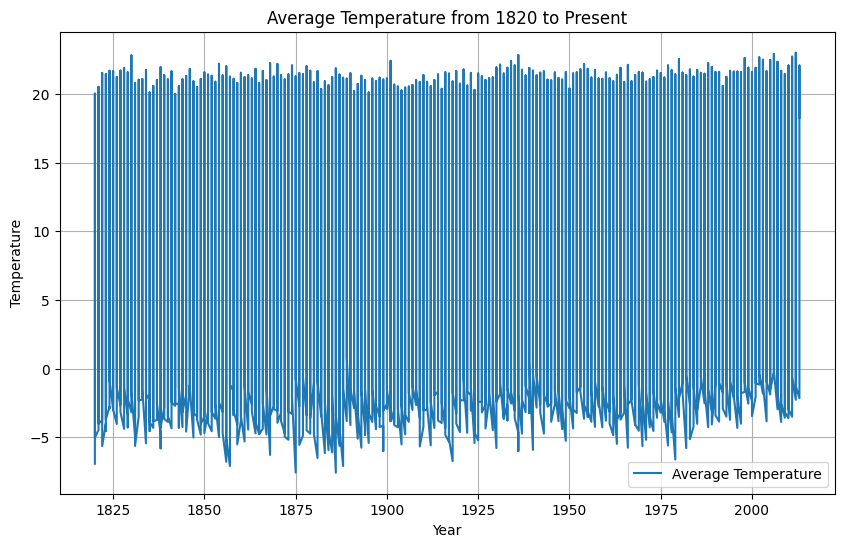

In [18]:
us_temp["dt"] = pd.to_datetime(us_temp["dt"], format="%Y-%m-%d")
us_temp["year"] = us_temp["dt"].dt.year
us_temp["month"] = us_temp["dt"].dt.month
us_temp_reindexed = us_temp.set_index("year")
us_temp_reindexed["AverageTemperature"] = us_temp_reindexed["AverageTemperature"].interpolate(method='linear')
us_temp_reindexed = us_temp_reindexed.reset_index()

plt.figure(figsize=(10, 6))
plt.plot(us_temp_reindexed['year'], us_temp_reindexed['AverageTemperature'], label='Average Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Average Temperature from 1820 to Present')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
us_temp['t'] = range(len(us_temp))

In [20]:
pre = us_temp[us_temp['year'] < 1920]
post = us_temp[us_temp['year'] >= 1920]

In [21]:
us_temp.head()

dt  AverageTemperature  AverageTemperatureUncertainty  \
555496 1820-01-01              -6.929                       0.733914   
555497 1820-02-01              -2.158                       0.563967   
555498 1820-03-01               1.227                       0.421650   
555499 1820-04-01               8.978                       0.374338   
555500 1820-05-01              13.647                       0.380394   

              Country  year  month  t  
555496  United States  1820      1  0  
555497  United States  1820      2  1  
555498  United States  1820      3  2  
555499  United States  1820      4  3  
555500  United States  1820      5  4

In [22]:
us_temp.tail()

dt  AverageTemperature  AverageTemperatureUncertainty  \
557816 2013-05-01              14.073                       0.023656   
557817 2013-06-01              20.198                       0.034633   
557818 2013-07-01              22.074                       0.018736   
557819 2013-08-01              21.168                       0.037093   
557820 2013-09-01              18.273                       0.218963   

              Country  year  month     t  
557816  United States  2013      5  2320  
557817  United States  2013      6  2321  
557818  United States  2013      7  2322  
557819  United States  2013      8  2323  
557820  United States  2013      9  2324

Helper Functions

In [23]:
# helper functions to support the analysis

def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (pt.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / pt.sqrt(n_out)
        out = pt.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.coords(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax, label=''):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3, label=label)


# default figure sizes
figsize = (10, 5)

import calendar
import os
# create a list of month strings, for plotting purposes
month_strings = calendar.month_name[1:]

In [24]:
us_temp['pre'] = us_temp['year'] < 1920


In [25]:
us_temp.head()

dt  AverageTemperature  AverageTemperatureUncertainty  \
555496 1820-01-01              -6.929                       0.733914   
555497 1820-02-01              -2.158                       0.563967   
555498 1820-03-01               1.227                       0.421650   
555499 1820-04-01               8.978                       0.374338   
555500 1820-05-01              13.647                       0.380394   

              Country  year  month  t   pre  
555496  United States  1820      1  0  True  
555497  United States  1820      2  1  True  
555498  United States  1820      3  2  True  
555499  United States  1820      4  3  True  
555500  United States  1820      5  4  True

<ipython-input-26-bdf60d1e87da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre['Year'] = pd.to_datetime(pre["dt"], format="%Y-%m-%d").dt.year


<Axes: xlabel='year', ylabel='AverageTemperature'>

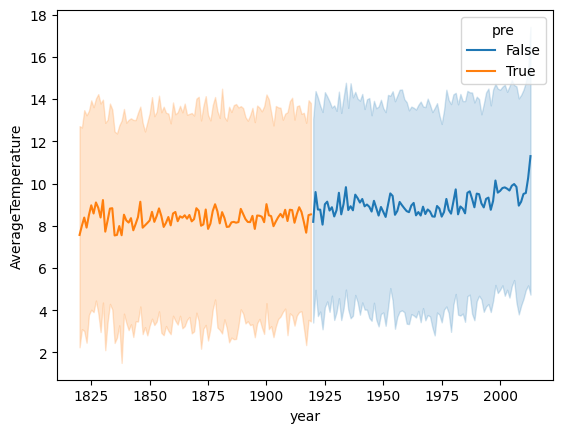

In [26]:
pre['Year'] = pd.to_datetime(pre["dt"], format="%Y-%m-%d").dt.year
ax = sns.lineplot(data=us_temp, x="year", y="AverageTemperature", hue="pre")
ax

#EDA PT. 2

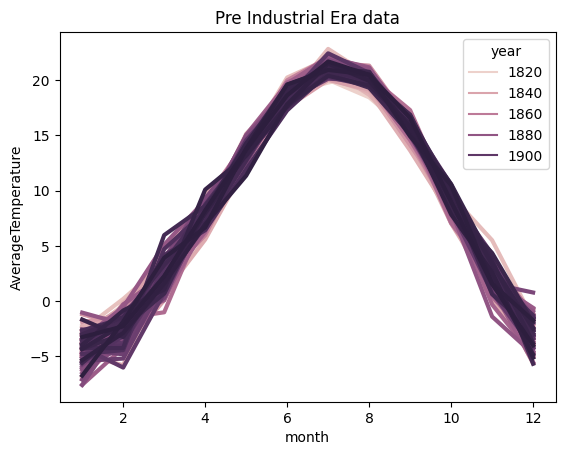

In [27]:
ax = sns.lineplot(data=pre, x="month", y="AverageTemperature", hue="year", lw=3)
ax.set(title="Pre Industrial Era data");

In [45]:
pre

AverageTemperature  AverageTemperatureUncertainty        Country  \
dt                                                                             
1820-01-01              -6.929                       0.733914  United States   
1820-02-01              -2.158                       0.563967  United States   
1820-03-01               1.227                       0.421650  United States   
1820-04-01               8.978                       0.374338  United States   
1820-05-01              13.647                       0.380394  United States   
...                        ...                            ...            ...   
1919-08-01              20.471                       0.047313  United States   
1919-09-01              16.578                       0.021575  United States   
1919-10-01               8.987                       0.029902  United States   
1919-11-01               1.538                       0.015897  United States   
1919-12-01              -4.003                       0.056964  United States   

            year  month     t  Year  dt_column  
dt                                              
1820-01-01  1820      1     0  1820 1820-01-01  
1820-02-01  1820      2     1  1820 1820-02-01  
1820-03-01  1820      3     2  1820 1820-03-01  
1820-04-01  1820      4     3  1820 1820-04-01  
1820-05-01  1820      5     4  1820 1820-05-01  
...          ...    ...   ...   ...        ...  
1919-08-01  1919      8  1195  1919 1919-08-01  
1919-09-01  1919      9  1196  1919 1919-09-01  
1919-10-01  1919     10  1197  1919 1919-10-01  
1919-11-01  1919     11  1198  1919 1919-11-01  
1919-12-01  1919     12  1199  1919 1919-12-01  

[1200 rows x 8 columns]

from matplotlib import pyplot as plt
pre['AverageTemperature'].plot(kind='hist', bins=20, title='AverageTemperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pre['AverageTemperatureUncertainty'].plot(kind='hist', bins=20, title='AverageTemperatureUncertainty')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pre['year'].plot(kind='hist', bins=20, title='year')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pre['month'].plot(kind='hist', bins=20, title='month')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pre.plot(kind='scatter', x='AverageTemperature', y='AverageTemperatureUncertainty', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pre.plot(kind='scatter', x='AverageTemperatureUncertainty', y='year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pre.plot(kind='scatter', x='year', y='month', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pre.plot(kind='scatter', x='month', y='t', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['dt_column']
  ys = series['AverageTemperature']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = pre.sort_values('dt_column', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dt_column')
_ = plt.ylabel('AverageTemperature')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['dt_column']
  ys = series['AverageTemperatureUncertainty']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = pre.sort_values('dt_column', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dt_column')
_ = plt.ylabel('AverageTemperatureUncertainty')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['dt_column']
  ys = series['month']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = pre.sort_values('dt_column', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dt_column')
_ = plt.ylabel('month')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['dt_column']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'dt_column'}, axis=1)
              .sort_values('dt_column', ascending=True))
  xs = counted['dt_column']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = pre.sort_values('dt_column', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dt_column')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
pre['AverageTemperature'].plot(kind='line', figsize=(8, 4), title='AverageTemperature')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
pre['AverageTemperatureUncertainty'].plot(kind='line', figsize=(8, 4), title='AverageTemperatureUncertainty')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
pre['year'].plot(kind='line', figsize=(8, 4), title='year')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
pre['month'].plot(kind='line', figsize=(8, 4), title='month')
plt.gca().spines[['top', 'right']].set_visible(False)

<ipython-input-53-43c09ccd9ab1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre['dt_column'] = pre['dt_column'].dt.year


Text(0, 0.5, 'Average Temperature')

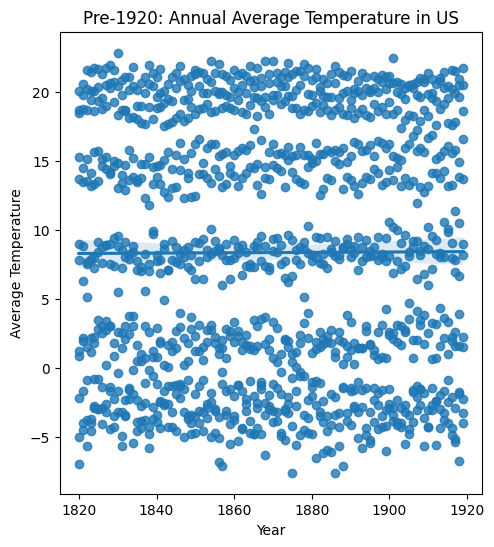

In [53]:
# prompt: Using dataframe pre: make a scatterplot of averagetemperature on yaxis and pre time as x axis

pre['dt_column'] = pre['dt_column'].dt.year

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.regplot(x='dt_column', y='AverageTemperature', data=pre)
plt.title('Pre-1920: Annual Average Temperature in US')
plt.xlabel('Year')
plt.ylabel('Average Temperature')

In [54]:
us_temp

AverageTemperature  AverageTemperatureUncertainty        Country  \
dt                                                                             
1820-01-01              -6.929                       0.733914  United States   
1820-02-01              -2.158                       0.563967  United States   
1820-03-01               1.227                       0.421650  United States   
1820-04-01               8.978                       0.374338  United States   
1820-05-01              13.647                       0.380394  United States   
...                        ...                            ...            ...   
2013-05-01              14.073                       0.023656  United States   
2013-06-01              20.198                       0.034633  United States   
2013-07-01              22.074                       0.018736  United States   
2013-08-01              21.168                       0.037093  United States   
2013-09-01              18.273                       0.218963  United States   

            year  month     t    pre  Year  dt_column  
dt                                                     
1820-01-01  1820      1     0   True  1820 1820-01-01  
1820-02-01  1820      2     1   True  1820 1820-02-01  
1820-03-01  1820      3     2   True  1820 1820-03-01  
1820-04-01  1820      4     3   True  1820 1820-04-01  
1820-05-01  1820      5     4   True  1820 1820-05-01  
...          ...    ...   ...    ...   ...        ...  
2013-05-01  2013      5  2320  False  2013 2013-05-01  
2013-06-01  2013      6  2321  False  2013 2013-06-01  
2013-07-01  2013      7  2322  False  2013 2013-07-01  
2013-08-01  2013      8  2323  False  2013 2013-08-01  
2013-09-01  2013      9  2324  False  2013 2013-09-01  

[2325 rows x 9 columns]

from matplotlib import pyplot as plt
us_temp['AverageTemperature'].plot(kind='hist', bins=20, title='AverageTemperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
us_temp['AverageTemperatureUncertainty'].plot(kind='hist', bins=20, title='AverageTemperatureUncertainty')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
us_temp['year'].plot(kind='hist', bins=20, title='year')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
us_temp['month'].plot(kind='hist', bins=20, title='month')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
us_temp.groupby('pre').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
us_temp.plot(kind='scatter', x='AverageTemperature', y='AverageTemperatureUncertainty', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
us_temp.plot(kind='scatter', x='AverageTemperatureUncertainty', y='year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
us_temp.plot(kind='scatter', x='year', y='month', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
us_temp.plot(kind='scatter', x='month', y='t', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['dt_column']
  ys = series['AverageTemperature']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = us_temp.sort_values('dt_column', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('pre')):
  _plot_series(series, series_name, i)
  fig.legend(title='pre', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dt_column')
_ = plt.ylabel('AverageTemperature')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['dt_column']
  ys = series['AverageTemperatureUncertainty']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = us_temp.sort_values('dt_column', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('pre')):
  _plot_series(series, series_name, i)
  fig.legend(title='pre', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dt_column')
_ = plt.ylabel('AverageTemperatureUncertainty')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['dt_column']
  ys = series['month']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = us_temp.sort_values('dt_column', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('pre')):
  _plot_series(series, series_name, i)
  fig.legend(title='pre', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dt_column')
_ = plt.ylabel('month')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['dt_column']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'dt_column'}, axis=1)
              .sort_values('dt_column', ascending=True))
  xs = counted['dt_column']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = us_temp.sort_values('dt_column', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('pre')):
  _plot_series(series, series_name, i)
  fig.legend(title='pre', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dt_column')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
us_temp['AverageTemperature'].plot(kind='line', figsize=(8, 4), title='AverageTemperature')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
us_temp['AverageTemperatureUncertainty'].plot(kind='line', figsize=(8, 4), title='AverageTemperatureUncertainty')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
us_temp['year'].plot(kind='line', figsize=(8, 4), title='year')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
us_temp['month'].plot(kind='line', figsize=(8, 4), title='month')
plt.gca().spines[['top', 'right']].set_visible(False)

TypeError: ignored

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(us_temp['pre'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(us_temp, x='AverageTemperature', y='pre', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

TypeError: ignored

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(us_temp['pre'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(us_temp, x='AverageTemperatureUncertainty', y='pre', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(us_temp['pre'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(us_temp, x='year', y='pre', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

TypeError: ignored

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(us_temp['pre'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(us_temp, x='month', y='pre', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# prompt: Using dataframe pre: make a scatterplot of averagetemperature on yaxis and pre time as x axis

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.regplot(x='dt_column', y='AverageTemperature', data=pre)
plt.title('Pre-1920: Annual Average Temperature in US')
plt.xlabel('Year')
plt.ylabel('Average Temperature')

In [28]:
us_temp["Year"] = us_temp["dt"].dt.year

In [29]:
us_temp.set_index('dt', inplace=True)
us_temp['dt_column'] = us_temp.index  # Create a separate column 'dt_column' with the 'dt' values

In [30]:
us_temp.head()

AverageTemperature  AverageTemperatureUncertainty        Country  \
dt                                                                             
1820-01-01              -6.929                       0.733914  United States   
1820-02-01              -2.158                       0.563967  United States   
1820-03-01               1.227                       0.421650  United States   
1820-04-01               8.978                       0.374338  United States   
1820-05-01              13.647                       0.380394  United States   

            year  month  t   pre  Year  dt_column  
dt                                                 
1820-01-01  1820      1  0  True  1820 1820-01-01  
1820-02-01  1820      2  1  True  1820 1820-02-01  
1820-03-01  1820      3  2  True  1820 1820-03-01  
1820-04-01  1820      4  3  True  1820 1820-04-01  
1820-05-01  1820      5  4  True  1820 1820-05-01

In [31]:
us_temp.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty', 'Country',
       'year', 'month', 't', 'pre', 'Year', 'dt_column'],
      dtype='object')

In [55]:
pre.describe()

AverageTemperature  AverageTemperatureUncertainty         year  \
count         1200.000000                    1200.000000  1200.000000   
mean             8.353013                       0.208651  1869.500000   
std              9.022758                       0.146460    28.878105   
min             -7.581000                       0.015897  1820.000000   
25%             -0.181000                       0.085920  1844.750000   
50%              8.242500                       0.182532  1869.500000   
75%             17.262750                       0.294285  1894.250000   
max             22.816000                       0.949659  1919.000000   

             month            t         Year    dt_column  
count  1200.000000  1200.000000  1200.000000  1200.000000  
mean      6.500000   599.500000  1869.500000  1869.500000  
std       3.453492   346.554469    28.878105    28.878105  
min       1.000000     0.000000  1820.000000  1820.000000  
25%       3.750000   299.750000  1844.750000  1844.750000  
50%       6.500000   599.500000  1869.500000  1869.500000  
75%       9.250000   899.250000  1894.250000  1894.250000  
max      12.000000  1199.000000  1919.000000  1919.000000

In [56]:
post.describe()

AverageTemperature  AverageTemperatureUncertainty         year  \
count         1125.000000                    1125.000000  1125.000000   
mean             9.060900                       0.024935  1966.376000   
std              8.891129                       0.014733    27.075516   
min             -6.620000                       0.000000  1920.000000   
25%              0.683000                       0.015519  1943.000000   
50%              9.214000                       0.022710  1966.000000   
75%             17.730000                       0.031416  1990.000000   
max             23.008000                       0.218963  2013.000000   

             month            t         Year  
count  1125.000000  1125.000000  1125.000000  
mean      6.488000  1762.000000  1966.376000  
std       3.450087   324.903832    27.075516  
min       1.000000  1200.000000  1920.000000  
25%       3.000000  1481.000000  1943.000000  
50%       6.000000  1762.000000  1966.000000  
75%       9.000000  2043.000000  1990.000000  
max      12.000000  2324.000000  2013.000000

In [33]:
post['Year'] = pd.to_datetime(post["dt"], format="%Y-%m-%d").dt.year


<ipython-input-33-d85f6e41aeca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post['Year'] = pd.to_datetime(post["dt"], format="%Y-%m-%d").dt.year


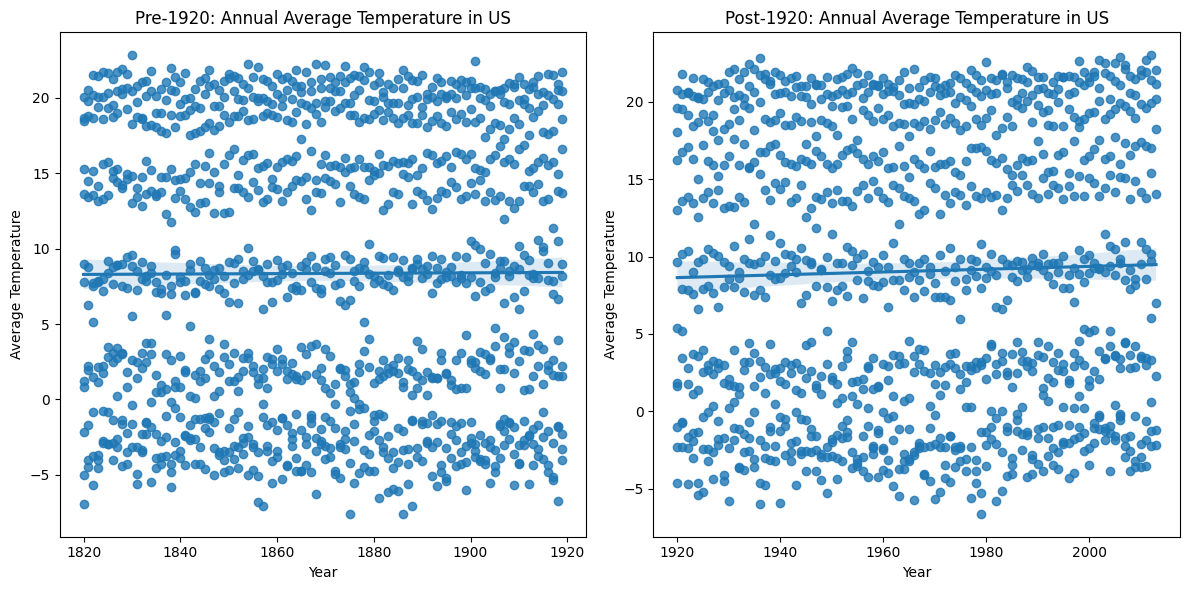

In [34]:
# Creating regression plots for pre-1840 and post-1840 periods
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.regplot(x='Year', y='AverageTemperature', data=pre)
plt.title('Pre-1920: Annual Average Temperature in US')
plt.xlabel('Year')
plt.ylabel('Average Temperature')

plt.subplot(1, 2, 2)
sns.regplot(x='Year', y='AverageTemperature', data=post)
plt.title('Post-1920: Annual Average Temperature in US')
plt.xlabel('Year')
plt.ylabel('Average Temperature')

plt.tight_layout()
plt.show()

#Bayesian Modeling

In [35]:
us_temp.head()

AverageTemperature  AverageTemperatureUncertainty        Country  \
dt                                                                             
1820-01-01              -6.929                       0.733914  United States   
1820-02-01              -2.158                       0.563967  United States   
1820-03-01               1.227                       0.421650  United States   
1820-04-01               8.978                       0.374338  United States   
1820-05-01              13.647                       0.380394  United States   

            year  month  t   pre  Year  dt_column  
dt                                                 
1820-01-01  1820      1  0  True  1820 1820-01-01  
1820-02-01  1820      2  1  True  1820 1820-02-01  
1820-03-01  1820      3  2  True  1820 1820-03-01  
1820-04-01  1820      4  3  True  1820 1820-04-01  
1820-05-01  1820      5  4  True  1820 1820-05-01

In [36]:
pre.set_index('dt', inplace=True)
pre['dt_column'] = pre.index
post.set_index('dt', inplace=True)
post['dt_column'] = post.index

<ipython-input-36-947e40b9c991>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre['dt_column'] = pre.index
<ipython-input-36-947e40b9c991>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post['dt_column'] = post.index


In [37]:
pre.head()

AverageTemperature  AverageTemperatureUncertainty        Country  \
dt                                                                             
1820-01-01              -6.929                       0.733914  United States   
1820-02-01              -2.158                       0.563967  United States   
1820-03-01               1.227                       0.421650  United States   
1820-04-01               8.978                       0.374338  United States   
1820-05-01              13.647                       0.380394  United States   

            year  month  t  Year  dt_column  
dt                                           
1820-01-01  1820      1  0  1820 1820-01-01  
1820-02-01  1820      2  1  1820 1820-02-01  
1820-03-01  1820      3  2  1820 1820-03-01  
1820-04-01  1820      4  3  1820 1820-04-01  
1820-05-01  1820      5  4  1820 1820-05-01

In [38]:
us_temp.describe()

AverageTemperature  AverageTemperatureUncertainty         year  \
count         2325.000000                    2325.000000  2325.000000   
mean             8.695539                       0.119756  1916.375484   
std              8.964368                       0.140016    55.942931   
min             -7.581000                       0.000000  1820.000000   
25%              0.337000                       0.022710  1868.000000   
50%              8.676000                       0.045799  1916.000000   
75%             17.528000                       0.191143  1965.000000   
max             23.008000                       0.949659  2013.000000   

             month           t         Year  
count  2325.000000  2325.00000  2325.000000  
mean      6.494194  1162.00000  1916.375484  
std       3.451107   671.31401    55.942931  
min       1.000000     0.00000  1820.000000  
25%       3.000000   581.00000  1868.000000  
50%       6.000000  1162.00000  1916.000000  
75%       9.000000  1743.00000  1965.000000  
max      12.000000  2324.00000  2013.000000

In [39]:
pre["month"].shape

(1200,)

In [40]:
pre.head()

AverageTemperature  AverageTemperatureUncertainty        Country  \
dt                                                                             
1820-01-01              -6.929                       0.733914  United States   
1820-02-01              -2.158                       0.563967  United States   
1820-03-01               1.227                       0.421650  United States   
1820-04-01               8.978                       0.374338  United States   
1820-05-01              13.647                       0.380394  United States   

            year  month  t  Year  dt_column  
dt                                           
1820-01-01  1820      1  0  1820 1820-01-01  
1820-02-01  1820      2  1  1820 1820-02-01  
1820-03-01  1820      3  2  1820 1820-03-01  
1820-04-01  1820      4  3  1820 1820-04-01  
1820-05-01  1820      5  4  1820 1820-05-01

In [41]:
random_seed= 8927
figsize= (10,6)

In [42]:
def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims=None, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (pt.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / pt.sqrt(n_out)
        out = pt.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coords(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


In [43]:
import theano.tensor as tt
class ZeroSumNormal(pm.Continuous):
    def __init__(self, mu=0, sigma=None, *args, **kwargs):
        super(ZeroSumNormal, self).__init__(*args, **kwargs)
        self.mu = mu
        self.sigma = sigma
        self.mean = 0  # Ensure the distribution is centered around zero

    def random(self, point=None, size=None):
        mu = self.mu
        sigma = self.sigma
        return np.random.normal(mu, sigma, size)

    def logp(self, value):
        sigma = self.sigma
        return tt.sum(pm.Normal.dist(self.mu, sigma).logp(value))  # Constrain the sum of values close to zero


In [57]:

# Define the Fourier series for seasonality
def fourier_series(x, n_terms=10):
    series = []
    for i in range(1, n_terms + 1):
        series.append(np.sin(2 * i * np.pi * x / 12))
        series.append(np.cos(2 * i * np.pi * x / 12))
    return np.asarray(series).T


with pm.Model(coords={"t": pre["t"], "seasonality_terms": range(1, 21)}) as industrial:
    # observed predictors and outcome
    month = pm.Data("month", pre["month"].to_numpy())
    time = pm.Data("time", pre["t"].to_numpy())
    avgtemp = pm.Data("avgtemp", pre["AverageTemperature"].to_numpy())

    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    month_mu = ZeroSumNormal("month_mu", mu=0, sigma=1)  # Assuming ZeroSumNormal is defined

    linear_trend = pm.TruncatedNormal("linear_trend", -7, 23, lower=0)  # Adjusted prior for trend

    seasonality = pm.Data("seasonality", fourier_series(pre["t"]), dims=("t", "seasonality_terms"))

    # Fourier series coefficients for seasonality
    seasonality_coeff = pm.Normal("seasonality_coeff", mu=0, sigma=1, dims=("seasonality_terms",))
    temp_coeff = pm.Normal("temp coeff", 0, 30)

    # the actual linear model with seasonality
    seasonal_effect = pm.math.dot(seasonality, seasonality_coeff)
    mu = pm.Deterministic("mu", intercept + seasonal_effect + (month_mu*month)+ linear_trend)
    sigma = pm.HalfNormal("sigma", 1)

    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=avgtemp)

    # Prior predictive samples
    prior_trace2 = pm.sample_prior_predictive()
    g = pm.model_to_graphviz()


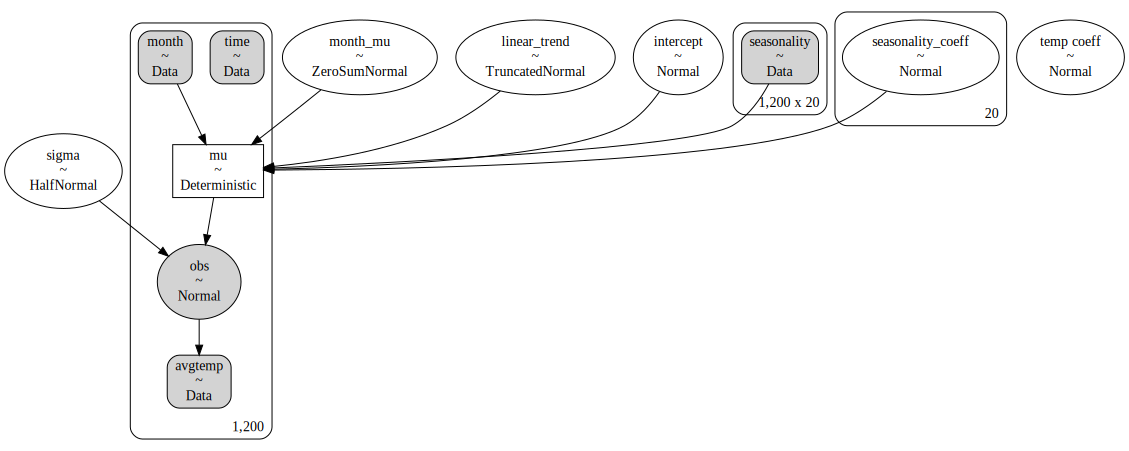

In [ ]:
g

In [ ]:
random_seed= 1234

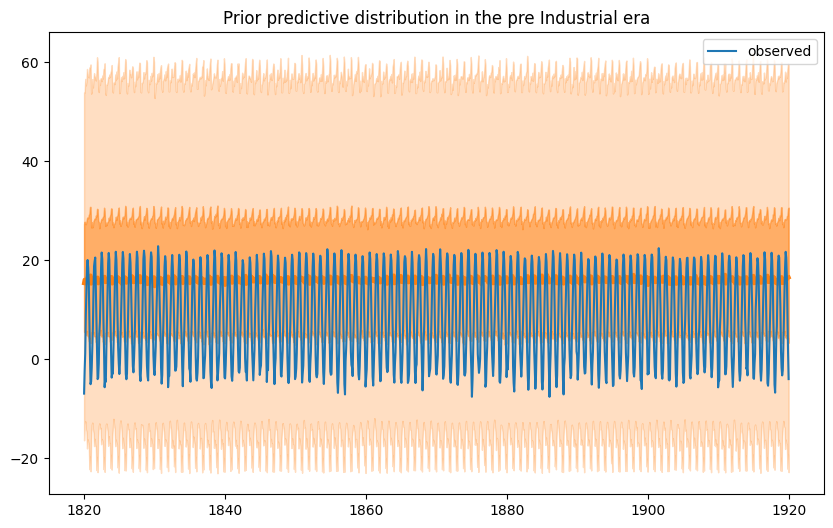

In [ ]:
def plot_xY(x, Y, ax, label=''):
    percentiles = np.percentile(Y, q=(2.5, 25, 50, 75, 97.5), axis=0)

    ax.plot(x, percentiles[2], color="C1", lw=3, label=label)  # Median
    ax.fill_between(x, percentiles[0], percentiles[4], alpha=0.25, color="C1")  # 95% interval
    ax.fill_between(x, percentiles[1], percentiles[3], alpha=0.5, color="C1")  # 50% interval


fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre.index, prior_trace["obs"], ax)
ax.plot(pre.index, pre["AverageTemperature"], label="observed")

ax.set(title="Prior predictive distribution in the pre Industrial era")
plt.legend();

In [59]:
# Group data by year
yearly_data = us_temp.groupby("Year")

# Find maximum and minimum temperatures for each year
pre2 = yearly_data["AverageTemperature"].max().reset_index(name="MaximumTemperature")
post2 = yearly_data["AverageTemperature"].min().reset_index(name="MinimumTemperature")


In [61]:
'''# Define a function to extract yearly max/min temperatures
def year_extremes(df):
    yearly_max = df.groupby("Year")["AverageTemperature"].max()
    yearly_min = df.groupby("Year")["AverageTemperature"].min()
    return pd.DataFrame({"Year": yearly_max.index, "MaxTemp": yearly_max, "MinTemp": yearly_min})

# Create a new pre-processing step
pre2 = year_extremes(us_temp)
'''

'# Define a function to extract yearly max/min temperatures\ndef year_extremes(df):\n    yearly_max = df.groupby("Year")["AverageTemperature"].max()\n    yearly_min = df.groupby("Year")["AverageTemperature"].min()\n    return pd.DataFrame({"Year": yearly_max.index, "MaxTemp": yearly_max, "MinTemp": yearly_min})\n\n# Create a new pre-processing step\npre2 = year_extremes(us_temp)\n'

In [62]:
def get_min_max_temperature_rows(df, year_column="year", temperature_column="AverageTemperature"):
    min_rows = df.groupby(year_column)[temperature_column].idxmin()
    max_rows = df.groupby(year_column)[temperature_column].idxmax()
    return pd.concat([df.loc[min_rows], df.loc[max_rows]], ignore_index=True)

# Create pre2 dataframe with min and max temperature rows for each year
pre2 = get_min_max_temperature_rows(pre, year_column="year", temperature_column="AverageTemperature")

# Reset index if needed (optional)
#
# Set the year column as the new index
pre2 = pre2.set_index("year")

# Ensure increasing order (optional)
pre2 = pre2.sort_index(ascending=True)# Print the new dataframe
pre2.head()



AverageTemperature  AverageTemperatureUncertainty        Country  month  \
year                                                                            
1820              -6.929                       0.733914  United States      1   
1820              20.031                       0.319076  United States      7   
1821              -4.464                       0.682248  United States      1   
1821              20.527                       0.396669  United States      8   
1822              -5.644                       0.501893  United States     12   

       t  Year  dt_column  
year                       
1820   0  1820       1820  
1820   6  1820       1820  
1821  12  1821       1821  
1821  19  1821       1821  
1822  35  1822       1822

In [64]:
# Create pre2 dataframe with min and max temperature rows for each year
post2 = get_min_max_temperature_rows(post, year_column="year", temperature_column="AverageTemperature")

# Reset index if needed (optional)
#
# Set the year column as the new index
post2 = post2.set_index("year")

# Ensure increasing order (optional)
post2 = post2.sort_index(ascending=True)# Print the new dataframe
post2.head()

AverageTemperature  AverageTemperatureUncertainty        Country  month  \
year                                                                            
1920              -4.624                       0.052801  United States      1   
1920              20.752                       0.038986  United States      7   
1921              21.784                       0.059992  United States      7   
1921              -2.321                       0.076836  United States      1   
1922              -4.678                       0.069076  United States      1   

         t  Year  dt_column  
year                         
1920  1200  1920 1920-01-01  
1920  1206  1920 1920-07-01  
1921  1218  1921 1921-07-01  
1921  1212  1921 1921-01-01  
1922  1224  1922 1922-01-01

In [65]:
with pm.Model(coords={"t": pre2["t"], "seasonality_terms": range(1, 21)}) as industrial:
    # observed predictors and outcome
    month = pm.Data("month", pre2["month"].to_numpy())
    time = pm.Data("time", pre2["t"].to_numpy())
    avgtemp = pm.Data("avgtemp", pre2["AverageTemperature"].to_numpy())

    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    month_mu = ZeroSumNormal("month_mu", mu=0, sigma=1)  # Assuming ZeroSumNormal is defined

    linear_trend = pm.TruncatedNormal("linear_trend", -7, 23, lower=0)  # Adjusted prior for trend

    seasonality = pm.Data("seasonality", fourier_series(pre2["t"]), dims=("t", "seasonality_terms"))

    # Fourier series coefficients for seasonality
    seasonality_coeff = pm.Normal("seasonality_coeff", mu=0, sigma=1, dims=("seasonality_terms",))
    temp_coeff = pm.Normal("temp coeff", 0, 30)

    # the actual linear model with seasonality
    seasonal_effect = pm.math.dot(seasonality, seasonality_coeff)
    mu = pm.Deterministic("mu", intercept + seasonal_effect + (month_mu*month)+ linear_trend)
    sigma = pm.HalfNormal("sigma", 1)

    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=avgtemp)

    # Prior predictive samples
    prior_trace2 = pm.sample_prior_predictive()
    g = pm.model_to_graphviz()


In [66]:
# prompt: start sampling with industrial model using metropolis as step

with industrial:
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, random_seed=random_seed)

/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [68]:
pm.summary(trace)


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept             -4.135  2.837  -9.105    0.036      1.308    0.989   
month_mu               0.930  0.375   0.290    1.506      0.179    0.138   
seasonality_coeff[1]  -0.781  0.956  -2.525    0.994      0.395    0.294   
seasonality_coeff[2]  -6.799  1.065  -8.648   -4.802      0.483    0.365   
seasonality_coeff[3]   2.355  1.027   0.371    4.027      0.388    0.287   
...                      ...    ...     ...      ...        ...      ...   
mu[196]               21.210  0.093  21.037   21.387      0.001    0.001   
mu[197]               -4.719  0.116  -4.935   -4.500      0.002    0.001   
mu[198]               -4.363  0.187  -4.713   -4.016      0.004    0.003   
mu[199]               21.210  0.093  21.037   21.387      0.001    0.001   
sigma                  0.913  0.046   0.826    0.997      0.001    0.000   

                      ess_bulk  ess_tail  r_hat  
intercept                  5.0      14.0   2.06  
month_mu                   5.0      25.0   2.39  
seasonality_coeff[1]       6.0      23.0   1.69  
seasonality_coeff[2]       5.0      29.0   2.09  
seasonality_coeff[3]       8.0      36.0   1.46  
...                        ...       ...    ...  
mu[196]                 5615.0   10854.0   1.00  
mu[197]                 4234.0    7723.0   1.00  
mu[198]                 2486.0    4610.0   1.00  
mu[199]                 5615.0   10854.0   1.00  
sigma                   4848.0    5347.0   1.00  

[225 rows x 9 columns]

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
<ipython-input-67-7793e4748a44>:4: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful resu

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'month_mu'}>,
        <Axes: title={'center': 'month_mu'}>],
       [<Axes: title={'center': 'seasonality_coeff'}>,
        <Axes: title={'center': 'seasonality_coeff'}>],
       [<Axes: title={'center': 'temp coeff'}>,
        <Axes: title={'center': 'temp coeff'}>],
       [<Axes: title={'center': 'linear_trend'}>,
        <Axes: title={'center': 'linear_trend'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

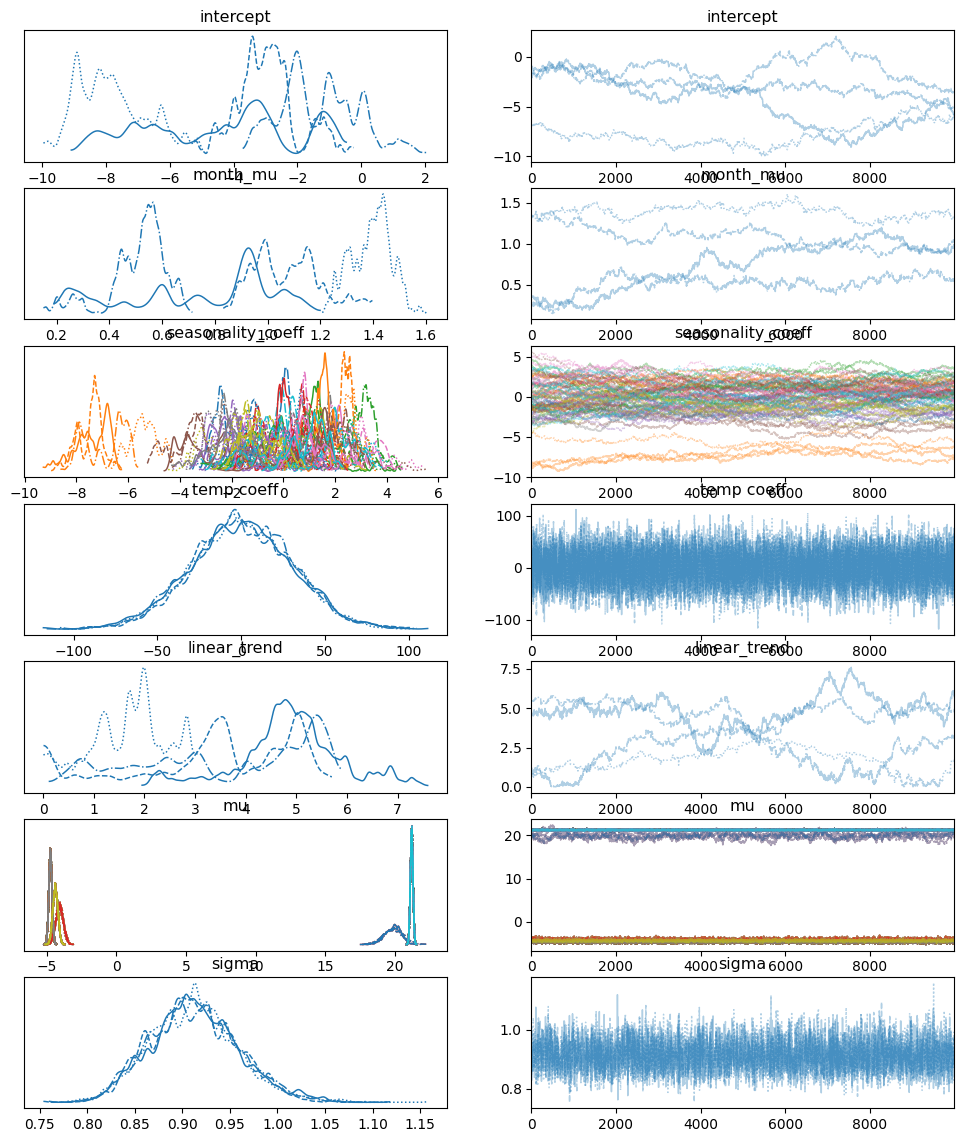

In [67]:
# prompt: show a summary and trace plots of trace

pm.traceplot(trace)


In [69]:
# prompt: with the trace plots and summary of trace, how can we improve the sampling parameters to get convergence

with industrial:
    step = pm.Metropolis(cores=4)
    trace = pm.sample(100000, step=step, random_seed=random_seed)
pm.summary(trace)


/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept             -6.366  3.448 -12.070   -0.315      0.929    0.731   
month_mu               1.051  0.258   0.561    1.494      0.048    0.036   
seasonality_coeff[1]  -0.431  0.984  -2.305    1.411      0.167    0.119   
seasonality_coeff[2]  -6.252  0.821  -7.832   -4.693      0.159    0.114   
seasonality_coeff[3]   2.209  0.972   0.479    4.017      0.101    0.072   
...                      ...    ...     ...      ...        ...      ...   
mu[196]               21.207  0.092  21.035   21.381      0.000    0.000   
mu[197]               -4.716  0.115  -4.931   -4.499      0.001    0.000   
mu[198]               -4.352  0.182  -4.696   -4.011      0.001    0.001   
mu[199]               21.207  0.092  21.035   21.381      0.000    0.000   
sigma                  0.911  0.046   0.826    1.000      0.000    0.000   

                      ess_bulk  ess_tail  r_hat  
intercept                 14.0      44.0   1.21  
month_mu                  27.0      45.0   1.12  
seasonality_coeff[1]      33.0     108.0   1.09  
seasonality_coeff[2]      26.0      83.0   1.13  
seasonality_coeff[3]      94.0     278.0   1.05  
...                        ...       ...    ...  
mu[196]                58052.0  101014.0   1.00  
mu[197]                45414.0   76437.0   1.00  
mu[198]                27356.0   51153.0   1.00  
mu[199]                58052.0  101014.0   1.00  
sigma                  40588.0   51715.0   1.00  

[225 rows x 9 columns]

In [74]:
with pm.Model(coords={"t": pre2["t"], "seasonality_terms": range(1, 21)}) as industrial:
    # observed predictors and outcome
    month = pm.Data("month", pre2["month"].to_numpy())
    time = pm.Data("time", pre2["t"].to_numpy())
    avgtemp = pm.Data("avgtemp", pre2["AverageTemperature"].to_numpy())

    # priors
    intercept = pm.StudentT("intercept", mu=0, sigma=10, nu=10, shape=1)
    month_mu = ZeroSumNormal("month_mu", mu=0, sigma=1)  # Assuming ZeroSumNormal is defined

    linear_trend = pm.TruncatedNormal("linear_trend", -7, 23, lower=0)  # Adjusted prior for trend

    seasonality = pm.Data("seasonality", fourier_series(pre2["t"]), dims=("t", "seasonality_terms"))

    # Fourier series coefficients for seasonality
    seasonality_coeff = pm.Normal("seasonality_coeff", mu=0, sigma=1, dims=("seasonality_terms",))
    temp_coeff = pm.Normal("temp coeff", 0, 30)

    # the actual linear model with seasonality
    seasonal_effect = pm.math.dot(seasonality, seasonality_coeff)
    mu = pm.Deterministic("mu", intercept + seasonal_effect + (month_mu*month)+ linear_trend)
    sigma = pm.HalfNormal("sigma", 1)

    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=avgtemp)

    # Prior predictive samples
    prior_trace2 = pm.sample_prior_predictive()
    g = pm.model_to_graphviz()


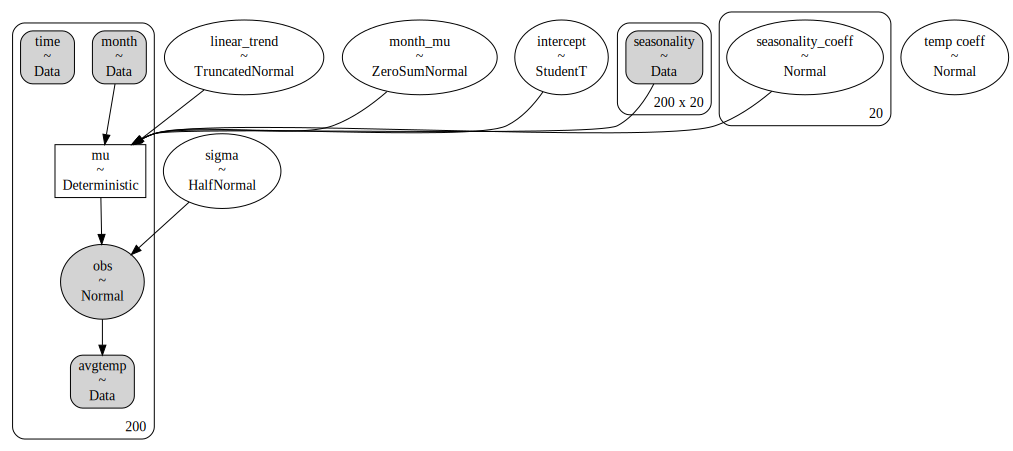

In [98]:
g

In [83]:
with industrial:
    step = pm.Metropolis(cores=4)
    trace1 = pm.sample(100000, step=step, random_seed=random_seed)
pm.summary(trace1)

/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept[0]          -6.203  3.531 -12.500   -0.289      0.806    0.579   
month_mu               1.057  0.287   0.524    1.542      0.051    0.038   
seasonality_coeff[1]  -0.443  0.967  -2.330    1.171      0.181    0.129   
seasonality_coeff[2]  -6.209  0.831  -7.714   -4.563      0.149    0.107   
seasonality_coeff[3]   2.176  0.968   0.431    4.022      0.098    0.072   
...                      ...    ...     ...      ...        ...      ...   
mu[196]               21.207  0.092  21.031   21.377      0.000    0.000   
mu[197]               -4.717  0.115  -4.932   -4.499      0.001    0.000   
mu[198]               -4.353  0.183  -4.696   -4.009      0.001    0.001   
mu[199]               21.207  0.092  21.031   21.377      0.000    0.000   
sigma                  0.911  0.047   0.826    1.000      0.000    0.000   

                      ess_bulk  ess_tail  r_hat  
intercept[0]              21.0     102.0   1.14  
month_mu                  32.0      31.0   1.09  
seasonality_coeff[1]      27.0      63.0   1.11  
seasonality_coeff[2]      31.0     147.0   1.11  
seasonality_coeff[3]      97.0     279.0   1.07  
...                        ...       ...    ...  
mu[196]                57391.0  102289.0   1.00  
mu[197]                45224.0   73858.0   1.00  
mu[198]                27790.0   50483.0   1.00  
mu[199]                57391.0  102289.0   1.00  
sigma                  40988.0   50895.0   1.00  

[225 rows x 9 columns]

<ipython-input-84-4f24c9a287da>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace1)
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'month_mu'}>,
        <Axes: title={'center': 'month_mu'}>],
       [<Axes: title={'center': 'seasonality_coeff'}>,
        <Axes: title={'center': 'seasonality_coeff'}>],
       [<Axes: title={'center': 'temp coeff'}>,
        <Axes: title={'center': 'temp coeff'}>],
       [<Axes: title={'center': 'linear_trend'}>,
        <Axes: title={'center': 'linear_trend'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

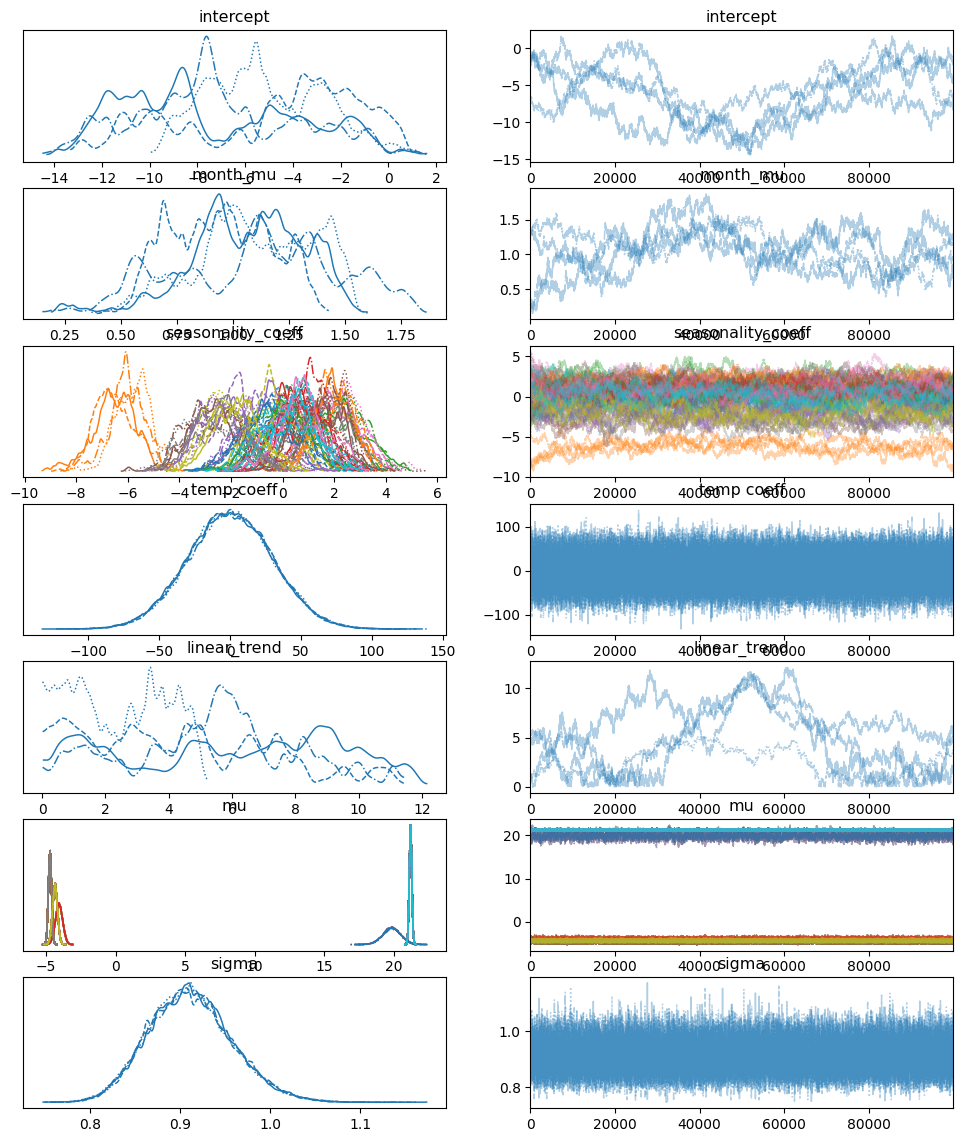

In [84]:
pm.traceplot(trace1)

In [86]:
trace1.keys

AttributeError: ignored

TypeError: ignored

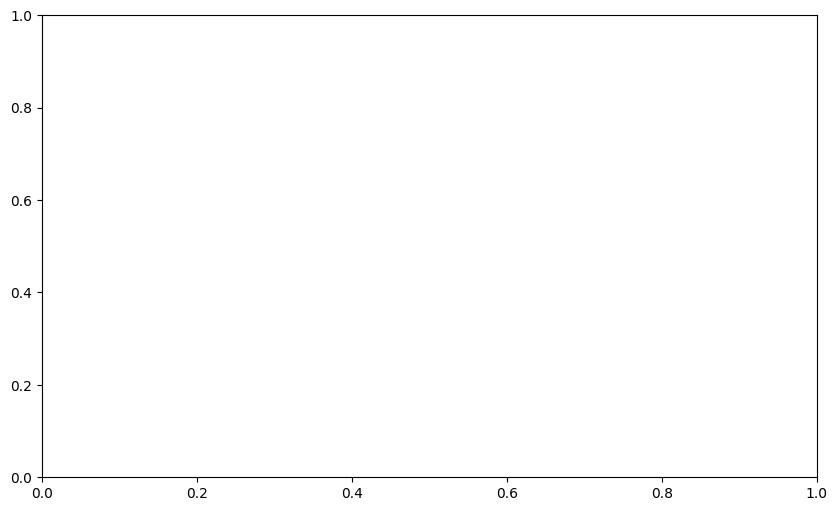

In [97]:
def plot_xY(x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975))
    az.plot_hdi(
        x, quantiles, ax=ax, color='k'
    )
fig, ax = plt.subplots(figsize=figsize)
pre2["AverageTemperature"] = pre2["AverageTemperature"].to_numpy().reshape((200, 1))
plot_xY(pre2["t"], pre2["AverageTemperature"], ax)
ax.plot(pre2["t"], trace1["obs"], label="observed")

ax.set(title="Posterior predictive distribution in the industrial era")
plt.legend();

In [77]:
with industrial:
    step = pm.Metropolis(cores=4)
    trace2 = pm.sample(200000, step=step, random_seed=random_seed)
pm.summary(trace)

/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept[0]          -7.136  4.287 -16.149   -0.091      1.282    0.978   
month_mu               1.048  0.298   0.499    1.625      0.036    0.026   
seasonality_coeff[1]  -0.479  0.939  -2.223    1.261      0.085    0.060   
seasonality_coeff[2]  -6.227  0.754  -7.610   -4.816      0.080    0.057   
seasonality_coeff[3]   2.051  0.929   0.330    3.806      0.071    0.052   
...                      ...    ...     ...      ...        ...      ...   
mu[196]               21.207  0.092  21.034   21.380      0.000    0.000   
mu[197]               -4.717  0.115  -4.930   -4.499      0.000    0.000   
mu[198]               -4.353  0.182  -4.693   -4.007      0.001    0.001   
mu[199]               21.207  0.092  21.034   21.380      0.000    0.000   
sigma                  0.911  0.047   0.824    0.998      0.000    0.000   

                      ess_bulk  ess_tail  r_hat  
intercept[0]              13.0      27.0   1.26  
month_mu                  70.0     106.0   1.04  
seasonality_coeff[1]     124.0     252.0   1.05  
seasonality_coeff[2]      90.0     217.0   1.06  
seasonality_coeff[3]     174.0     400.0   1.03  
...                        ...       ...    ...  
mu[196]               112331.0  200907.0   1.00  
mu[197]                91154.0  148349.0   1.00  
mu[198]                53735.0  101680.0   1.00  
mu[199]               112331.0  200907.0   1.00  
sigma                  77994.0   98669.0   1.00  

[225 rows x 9 columns]

<ipython-input-78-4b673fced3da>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'month_mu'}>,
        <Axes: title={'center': 'month_mu'}>],
       [<Axes: title={'center': 'seasonality_coeff'}>,
        <Axes: title={'center': 'seasonality_coeff'}>],
       [<Axes: title={'center': 'temp coeff'}>,
        <Axes: title={'center': 'temp coeff'}>],
       [<Axes: title={'center': 'linear_trend'}>,
        <Axes: title={'center': 'linear_trend'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

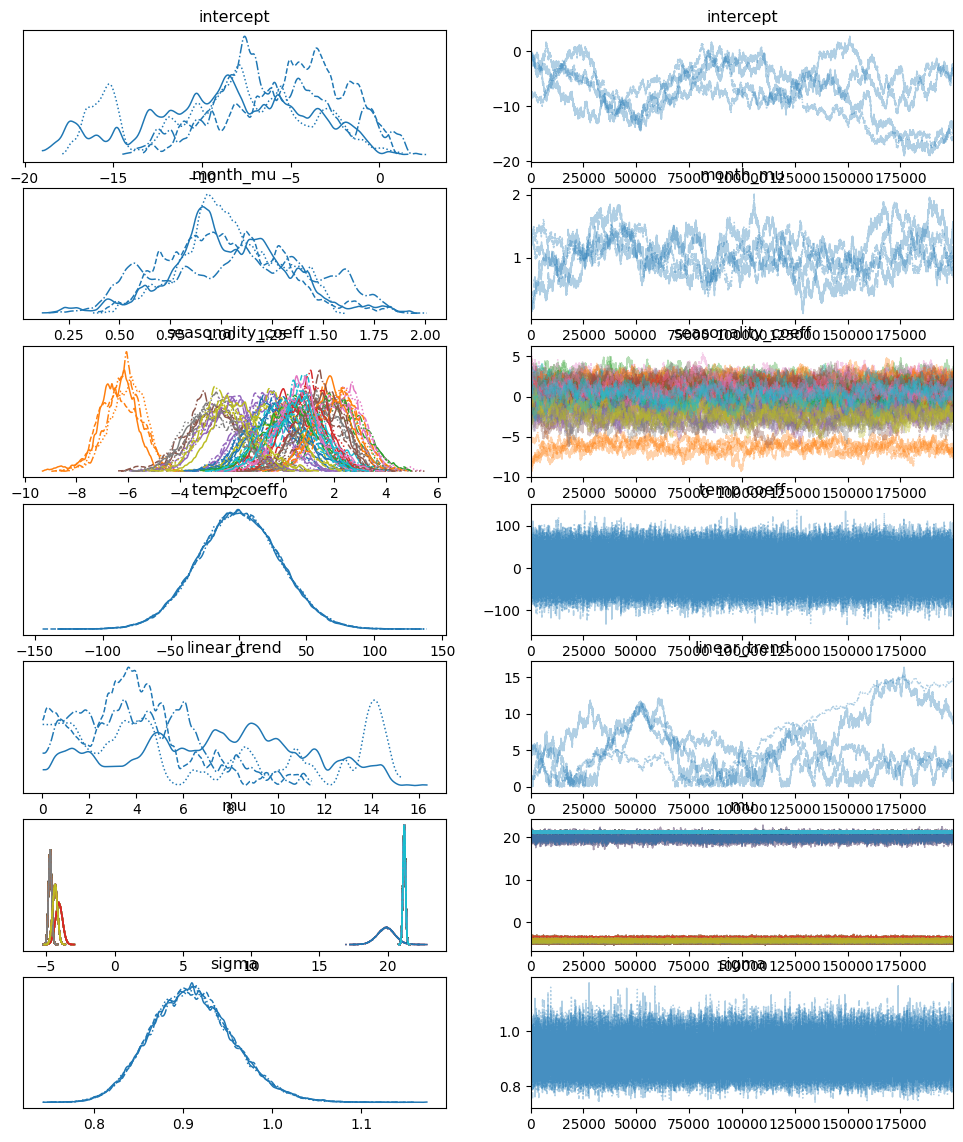

In [78]:
pm.traceplot(trace2)

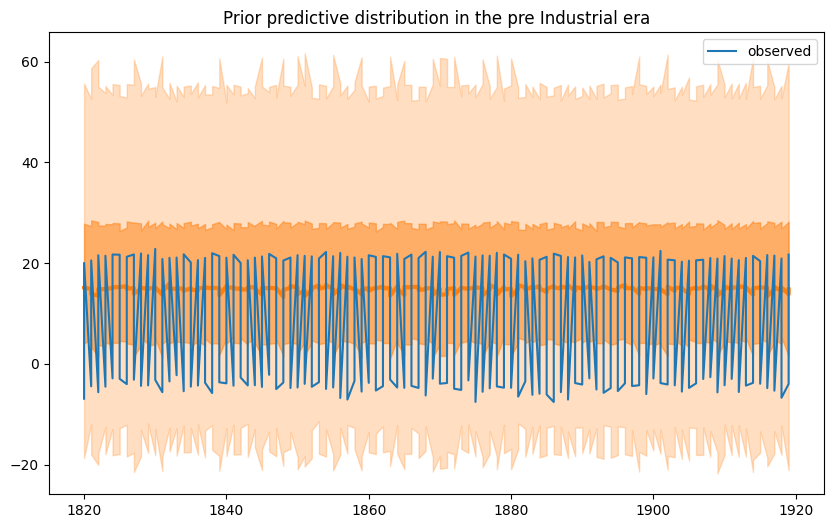

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre2.index, prior_trace2["obs"], ax)
ax.plot(pre2.index, pre2["AverageTemperature"], label="observed")

ax.set(title="Prior predictive distribution in the pre Industrial era")
plt.legend();

In [ ]:
# Define function to filter max temperature rows
def filter_max_temperature(df, year_column="year", temperature_column="AverageTemperature"):
    max_rows = df.groupby(year_column)[temperature_column].idxmax()
    return df.loc[max_rows]

# Apply function to pre and store in pre3
pre3 = filter_max_temperature(pre, year_column="year", temperature_column="AverageTemperature")

# Apply function to post and store in post3
post3 = filter_max_temperature(post, year_column="year", temperature_column="AverageTemperature")

# Print the new dataframes (optional)
pre3.head()

AverageTemperature  AverageTemperatureUncertainty        Country  \
dt                                                                             
1820-07-01              20.031                       0.319076  United States   
1821-08-01              20.527                       0.396669  United States   
1822-07-01              21.539                       0.288418  United States   
1823-07-01              21.453                       0.289553  United States   
1824-07-01              21.696                       0.554883  United States   

            year  month   t  Year  dt_column  
dt                                            
1820-07-01  1820      7   6  1820 1820-07-01  
1821-08-01  1821      8  19  1821 1821-08-01  
1822-07-01  1822      7  30  1822 1822-07-01  
1823-07-01  1823      7  42  1823 1823-07-01  
1824-07-01  1824      7  54  1824 1824-07-01

In [ ]:
post3.head()

AverageTemperature  AverageTemperatureUncertainty        Country  \
dt                                                                             
1920-07-01              20.752                       0.038986  United States   
1921-07-01              21.784                       0.059992  United States   
1922-07-01              20.617                       0.035958  United States   
1923-07-01              21.530                       0.028388  United States   
1924-07-01              20.300                       0.033687  United States   

            year  month     t  Year  dt_column  
dt                                              
1920-07-01  1920      7  1206  1920 1920-07-01  
1921-07-01  1921      7  1218  1921 1921-07-01  
1922-07-01  1922      7  1230  1922 1922-07-01  
1923-07-01  1923      7  1242  1923 1923-07-01  
1924-07-01  1924      7  1254  1924 1924-07-01

In [ ]:
from pymc3.step_methods.metropolis import Metropolis
with pm.Model(coords={"t": pre3["t"], "seasonality_terms": range(1, 21)}) as industrial:
    # observed predictors and outcome
    month = pm.Data("month", pre3["month"].to_numpy())
    time = pm.Data("time", pre3["t"].to_numpy())
    avgtemp = pm.Data("avgtemp", pre3["AverageTemperature"].to_numpy())

    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    month_mu = ZeroSumNormal("month_mu", mu=0, sigma=1)  # Assuming ZeroSumNormal is defined

    linear_trend = pm.TruncatedNormal("linear_trend", -7, 23, lower=0)  # Adjusted prior for trend

    seasonality = pm.Data("seasonality", fourier_series(pre3["t"]), dims=("t", "seasonality_terms"))

    # Fourier series coefficients for seasonality
    seasonality_coeff = pm.Normal("seasonality_coeff", mu=0, sigma=1, dims=("seasonality_terms",))
    temp_coeff = pm.Normal("temp coeff", 0, 30)

    # the actual linear model with seasonality
    seasonal_effect = pm.math.dot(seasonality, seasonality_coeff)
    mu = pm.Deterministic("mu", intercept + seasonal_effect + (month_mu*month)+ linear_trend)
    sigma = pm.HalfNormal("sigma", 1)

    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=avgtemp)
    metropolis = Metropolis()


    # Prior predictive samples
    prior_trace3 = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, step=metropolis)
    g = pm.model_to_graphviz()

/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


AttributeError: ignored

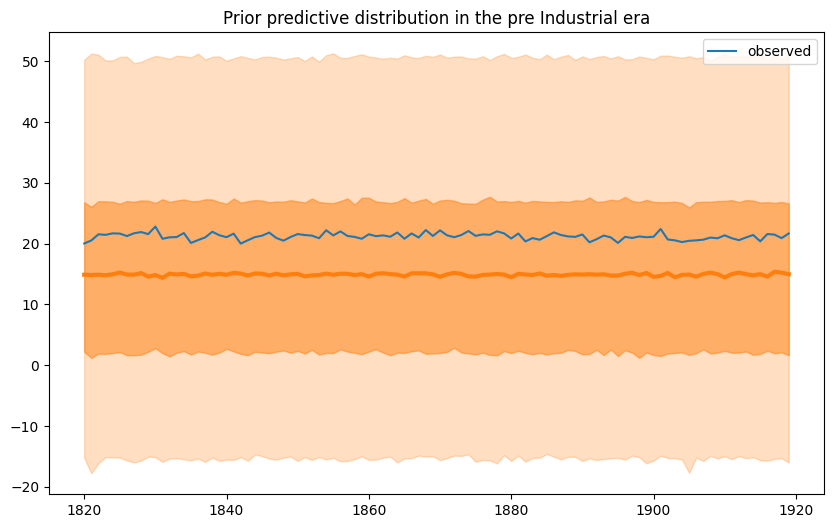

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre2.index, prior_trace2["obs"], ax)
ax.plot(pre2.index, pre3["AverageTemperature"], label="observed")

ax.set(title="Prior predictive distribution in the pre Industrial era")
plt.legend();

TypeError: ignored